In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist
%matplotlib inline

In [2]:
np.random.seed(42)

In [3]:
customers_df = pd.read_csv('Customers.csv')
transactions_df = pd.read_csv('Transactions.csv')

In [4]:
def create_customer_features(customers_df, transactions_df):
    """Create comprehensive customer features for clustering"""
    
    # Process customer data
    customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'])
    reference_date = pd.to_datetime('2025-01-27')
    customers_df['AccountAge'] = (reference_date - customers_df['SignupDate']).dt.days
    
    # One-hot encode region
    region_dummies = pd.get_dummies(customers_df['Region'], prefix='Region')
    
    # Transaction features
    transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'])
    
    # RFM Analysis
    latest_date = transactions_df['TransactionDate'].max()
    
    rfm = transactions_df.groupby('CustomerID').agg({
        'TransactionDate': lambda x: (latest_date - x.max()).days,  # Recency
        'TransactionID': 'count',  # Frequency
        'TotalValue': 'sum'  # Monetary
    }).rename(columns={
        'TransactionDate': 'Recency',
        'TransactionID': 'Frequency',
        'TotalValue': 'Monetary'
    })
    
    # Additional transaction metrics
    transaction_metrics = transactions_df.groupby('CustomerID').agg({
        'Quantity': ['sum', 'mean', 'std'],
        'TotalValue': ['mean', 'std']
    }).fillna(0)
    
    # Flatten column names
    transaction_metrics.columns = [f"{col[0]}_{col[1]}" for col in transaction_metrics.columns]
    
    # Purchase patterns
    transactions_df['Month'] = transactions_df['TransactionDate'].dt.month
    monthly_frequency = pd.crosstab(transactions_df['CustomerID'], transactions_df['Month'])
    monthly_frequency.columns = [f'Month_{col}_freq' for col in monthly_frequency.columns]
    
    # Average time between purchases
    def calc_avg_purchase_gap(group):
        if len(group) <= 1:
            return 0
        dates = sorted(group['TransactionDate'])
        gaps = [(dates[i+1] - dates[i]).days for i in range(len(dates)-1)]
        return np.mean(gaps) if gaps else 0
    
    avg_purchase_gaps = transactions_df.groupby('CustomerID').apply(calc_avg_purchase_gap)
    avg_purchase_gaps = pd.DataFrame(avg_purchase_gaps, columns=['AvgPurchaseGap'])
    
    # Combine all features
    features_df = pd.DataFrame(index=customers_df['CustomerID'])
    features_df['AccountAge'] = customers_df.set_index('CustomerID')['AccountAge']
    features_df = pd.concat([
        features_df,
        region_dummies,
        rfm,
        transaction_metrics,
        monthly_frequency,
        avg_purchase_gaps
    ], axis=1).fillna(0)
    
    return features_df

# Create feature matrix
print("Creating features...")
features_df = create_customer_features(customers_df, transactions_df)

Creating features...


In [5]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_df)
scaled_features_df = pd.DataFrame(scaled_features, columns=features_df.columns, index=features_df.index)

In [6]:
def davies_bouldin_score(X, labels):
    n_clusters = len(np.unique(labels))
    cluster_centers = np.array([X[labels == i].mean(axis=0) for i in range(n_clusters)])
    
    # Calculate cluster dispersions (average distance to center)
    dispersions = np.zeros(n_clusters)
    for i in range(n_clusters):
        cluster_points = X[labels == i]
        if len(cluster_points) > 0:
            dispersions[i] = np.mean(cdist(cluster_points, [cluster_centers[i]]))
    
    # Calculate Davies-Bouldin Index
    db_matrix = np.zeros((n_clusters, n_clusters))
    for i in range(n_clusters):
        for j in range(i + 1, n_clusters):
            cluster_distance = np.linalg.norm(cluster_centers[i] - cluster_centers[j])
            if cluster_distance != 0:
                db_matrix[i, j] = (dispersions[i] + dispersions[j]) / cluster_distance
                db_matrix[j, i] = db_matrix[i, j]
    
    # Calculate the final DB index
    db_index = np.mean([np.max(row[row != 0]) for row in db_matrix if np.any(row != 0)])
    return db_index

# 5. Find optimal number of clusters
def evaluate_clusters(X, max_clusters=10):
    """Evaluate different numbers of clusters using multiple metrics"""
    metrics = {
        'n_clusters': [],
        'silhouette': [],
        'calinski': [],
        'davies_bouldin': [],
        'inertia': []
    }
    
    for n in range(2, max_clusters + 1):
        print(f"Evaluating {n} clusters...")
        kmeans = KMeans(n_clusters=n, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X)
        
        metrics['n_clusters'].append(n)
        metrics['silhouette'].append(silhouette_score(X, labels))
        metrics['calinski'].append(calinski_harabasz_score(X, labels))
        metrics['davies_bouldin'].append(davies_bouldin_score(X, labels))
        metrics['inertia'].append(kmeans.inertia_)
    
    return pd.DataFrame(metrics)

Evaluating 2 clusters...
Evaluating 3 clusters...
Evaluating 4 clusters...
Evaluating 5 clusters...
Evaluating 6 clusters...
Evaluating 7 clusters...
Evaluating 8 clusters...
Evaluating 9 clusters...
Evaluating 10 clusters...


Text(0, 0.5, 'Score')

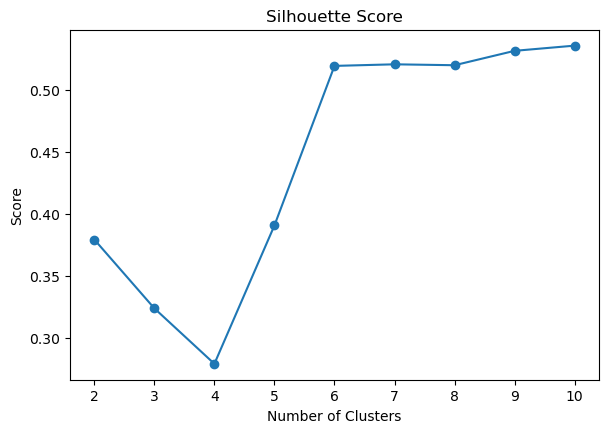

In [7]:
cluster_metrics = evaluate_clusters(scaled_features)

# 6. Visualize evaluation metrics
plt.figure(figsize=(15, 10))

# Silhouette Score
plt.subplot(2, 2, 1)
plt.plot(cluster_metrics['n_clusters'], cluster_metrics['silhouette'], marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')

Text(0, 0.5, 'Score')

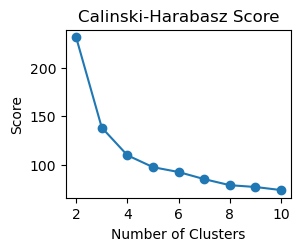

In [8]:
plt.subplot(2, 2, 2)
plt.plot(cluster_metrics['n_clusters'], cluster_metrics['calinski'], marker='o')
plt.title('Calinski-Harabasz Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')

Text(0, 0.5, 'Score')

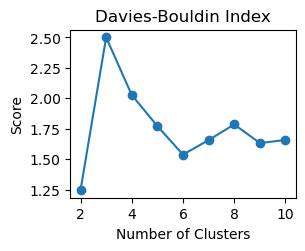

In [9]:
plt.subplot(2, 2, 3)
plt.plot(cluster_metrics['n_clusters'], cluster_metrics['davies_bouldin'], marker='o')
plt.title('Davies-Bouldin Index')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')

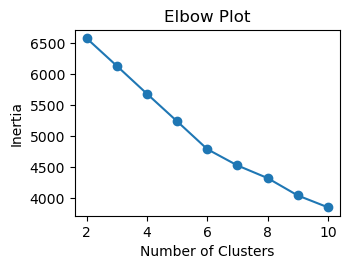

In [10]:
plt.subplot(2, 2, 4)
plt.plot(cluster_metrics['n_clusters'], cluster_metrics['inertia'], marker='o')
plt.title('Elbow Plot')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')

plt.tight_layout()
plt.show()


Optimal number of clusters based on Davies-Bouldin Index: 2

Cluster Profiles:
         AccountAge  Region_Asia  Region_Europe  Region_North America  \
Cluster                                                                 
0        564.394737     0.000000       0.000000              0.000000   
1         20.447619     0.214286       0.238095              0.219048   

         Region_South America    Recency  Frequency     Monetary  \
Cluster                                                            
0                    0.000000  68.389474   5.215789  3613.299158   
1                    0.280952   8.142857   0.042857    16.517714   

         Quantity_sum  Quantity_mean  ...  Month_4_freq  Month_5_freq  \
Cluster                               ...                               
0           13.257895       2.555939  ...      0.452632      0.442105   
1            0.085714       0.085714  ...      0.000000      0.009524   

         Month_6_freq  Month_7_freq  Month_8_freq  Month_9_fr

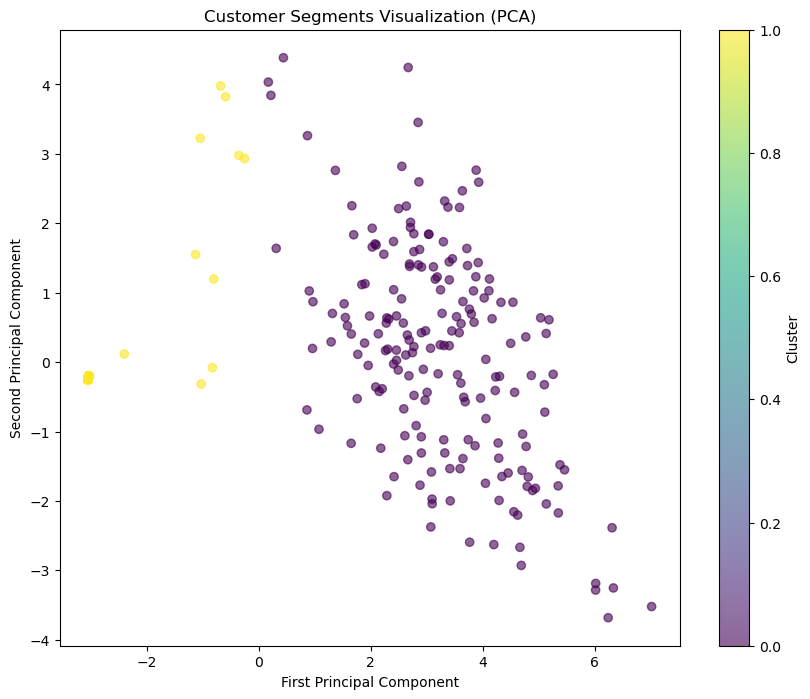

In [11]:
optimal_clusters = cluster_metrics.loc[cluster_metrics['davies_bouldin'].idxmin(), 'n_clusters']
print(f"\nOptimal number of clusters based on Davies-Bouldin Index: {optimal_clusters}")

# Fit final model
final_kmeans = KMeans(n_clusters=int(optimal_clusters), random_state=42, n_init=10)
cluster_labels = final_kmeans.fit_predict(scaled_features)

# 8. Analyze clusters
# Add cluster labels to original data
features_df['Cluster'] = cluster_labels

# Calculate cluster profiles
cluster_profiles = features_df.groupby('Cluster').mean()
print("\nCluster Profiles:")
print(cluster_profiles)

# 9. Visualize final clusters using PCA
from sklearn.decomposition import PCA

# Reduce dimensions to 2D
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)

# Create visualization
plt.figure(figsize=(10, 8))
scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], 
                     c=cluster_labels, cmap='viridis', alpha=0.6)
plt.title('Customer Segments Visualization (PCA)')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar(scatter, label='Cluster')
plt.show()

In [12]:
def analyze_clusters(features_df, cluster_labels):
    """Generate detailed characteristics for each cluster"""
    cluster_stats = []
    
    for cluster in range(int(optimal_clusters)):
        cluster_data = features_df[features_df['Cluster'] == cluster]
        
        # Calculate key metrics
        stats = {
            'Cluster_Size': len(cluster_data),
            'Avg_Monetary': cluster_data['Monetary'].mean(),
            'Avg_Frequency': cluster_data['Frequency'].mean(),
            'Avg_Recency': cluster_data['Recency'].mean(),
            'Avg_PurchaseGap': cluster_data['AvgPurchaseGap'].mean()
        }
        
        cluster_stats.append(stats)
    
    return pd.DataFrame(cluster_stats)

# Print cluster characteristics
cluster_analysis = analyze_clusters(features_df, cluster_labels)
print("\nCluster Characteristics:")
print(cluster_analysis)

# Save results
results = {
    'optimal_clusters': int(optimal_clusters),
    'davies_bouldin_index': cluster_metrics.loc[cluster_metrics['davies_bouldin'].idxmin(), 'davies_bouldin'],
    'silhouette_score': cluster_metrics.loc[cluster_metrics['davies_bouldin'].idxmin(), 'silhouette'],
    'calinski_harabasz_score': cluster_metrics.loc[cluster_metrics['davies_bouldin'].idxmin(), 'calinski']
}

print("\nFinal Clustering Results:")
for metric, value in results.items():
    print(f"{metric}: {value}")

# Export results if needed
features_df.to_csv('customer_segments.csv')


Cluster Characteristics:
   Cluster_Size  Avg_Monetary  Avg_Frequency  Avg_Recency  Avg_PurchaseGap
0           190   3613.299158       5.215789    68.389474        65.372759
1           210     16.517714       0.042857     8.142857         0.000000

Final Clustering Results:
optimal_clusters: 2
davies_bouldin_index: 1.2474838510636737
silhouette_score: 0.37966326893798324
calinski_harabasz_score: 231.48576300083258
